### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1_rst.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')
ds.data.head()

,MSP,RST,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,
2015-02-01 00:00:00-05:00,23.00,24.08,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,24.08,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,23.00,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,19.94,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,19.04,10432,10700.09


Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [2]:
features = ['MSP', 'RST', ds.actual]
df = ds.data[features].copy()
load = ds.data[ds.actual].copy().to_numpy()

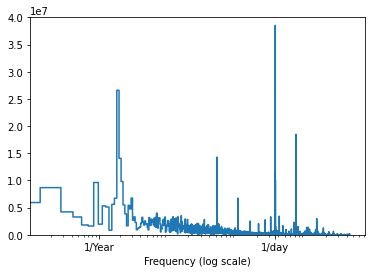

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

fft = tf.signal.rfft(load)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(load)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [4]:
f_per_year[np.argwhere(np.abs(fft) > 1e7).flatten()]

array([  0.        ,   1.95471468,   2.09433716,  52.21880642,
       364.27504266, 365.2524    , 366.22975734, 730.5048    ])

Create yearly, weekly, and daily signals.

In [4]:
import pandas as pd
day = 24*60*60
year = (365.2425)*day
timestamp_s = df.index.to_series().map(pd.Timestamp.timestamp)
df['Daily sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Daily cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Weekly sin'] = np.sin(timestamp_s * (2 * np.pi / (7*day)))
df['Weekly cos'] = np.cos(timestamp_s * (2 * np.pi / (7*day)))
df['Yearly sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Yearly cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

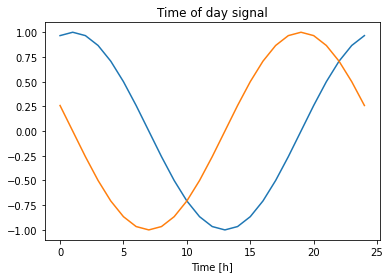

In [6]:
plt.plot(np.array(df['Daily sin'])[:25])
plt.plot(np.array(df['Daily cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [5]:
raw_data = df.to_numpy()
num_test_samples = num_val_samples = 365 * 24
num_train_samples = len(raw_data) - num_test_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
import numpy as np
from tensorflow import keras

sampling_rate = 1
sequence_length = 24*8
delay = sampling_rate * (sequence_length + 24 - 1) 
#delay = sampling_rate * sequence_length

batch_size = 32 # hyperparameter
should_shuffle = True

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [22]:
from datetime import datetime

def evaluate(model, optimizer="adamax", loss="mse", epochs=10, checkpoint_file=None, patience=3):
    ts = datetime.now().strftime ("%Y%m%d_%H%M%S")
    checkpoint_file = checkpoint_file or f"load_prediction_{optimizer}_{loss}_{ts}.keras"
    logdir = f"logs/fit/{ts}"
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_file, monitor='val_mae', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=patience),
        keras.callbacks.TensorBoard(log_dir=logdir)]
    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model(checkpoint_file)
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history, checkpoint_file


In [24]:
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Dense(32, activation='leaky_relu')(inputs)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation='leaky_relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

history, checkpoint_file = evaluate(model, epochs=15)

Epoch 1/15
1409/1409 [==============================] - 943s 545ms/step - loss: 111678856.0000 - mae: 10428.8418 - val_loss: 76714696.0000 - val_mae: 8601.3271
Epoch 2/15
1409/1409 [==============================] - 741s 526ms/step - loss: 50108908.0000 - mae: 6710.3687 - val_loss: 13370600.0000 - val_mae: 3263.1567
Epoch 3/15
1409/1409 [==============================] - 771s 547ms/step - loss: 5961770.5000 - mae: 1941.8898 - val_loss: 2956412.2500 - val_mae: 1413.7096
Epoch 4/15
1409/1409 [==============================] - 846s 600ms/step - loss: 3190412.5000 - mae: 1429.7313 - val_loss: 2956038.7500 - val_mae: 1413.6057
Epoch 5/15
1409/1409 [==============================] - 835s 592ms/step - loss: 3178399.7500 - mae: 1429.9214 - val_loss: 2964267.0000 - val_mae: 1415.9105
Epoch 6/15
1409/1409 [==============================] - 844s 599ms/step - loss: 2006021.1250 - mae: 1105.8503 - val_loss: 844644.8750 - val_mae: 713.6856
Epoch 7/15
1409/1409 [==============================] - 839s

load_prediction_adamax_mse_20220507_113813.keras


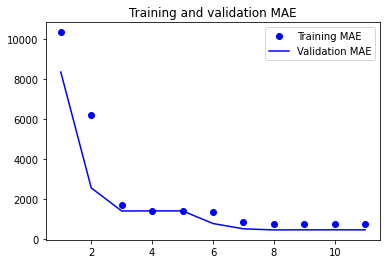

In [13]:
print(checkpoint_file)
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [14]:
model = keras.models.load_model(checkpoint_file)

In [16]:
history2, checkpoint_file2 = evaluate(model, epochs=250, patience=5)

Epoch 1/250
1409/1409 [==============================] - 1282s 783ms/step - loss: 957487.7500 - mae: 764.8640 - val_loss: 403189.8125 - val_mae: 461.2744
Epoch 2/250
1409/1409 [==============================] - 1018s 722ms/step - loss: 928819.0000 - mae: 752.3331 - val_loss: 380973.5625 - val_mae: 449.1143
Epoch 3/250
1409/1409 [==============================] - 1017s 722ms/step - loss: 915604.0625 - mae: 747.9287 - val_loss: 375641.7500 - val_mae: 442.5204
Epoch 4/250
1409/1409 [==============================] - 1016s 721ms/step - loss: 910189.6875 - mae: 745.4193 - val_loss: 376319.7500 - val_mae: 446.7002
Epoch 5/250
1409/1409 [==============================] - 1018s 723ms/step - loss: 893630.6250 - mae: 736.8245 - val_loss: 379139.9375 - val_mae: 455.1604
Epoch 6/250
1409/1409 [==============================] - 1017s 722ms/step - loss: 889592.0625 - mae: 737.6060 - val_loss: 401403.4375 - val_mae: 470.9376
Epoch 7/250
1409/1409 [==============================] - 1005s 713ms/step - 

load_prediction_adamax_mse_20220507_113813.keras


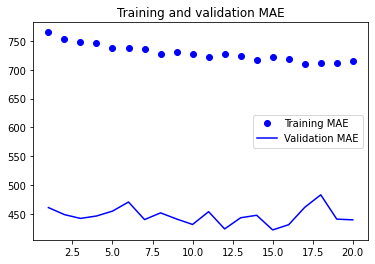

In [18]:
print(checkpoint_file)
import matplotlib.pyplot as plt
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [20]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.8.0


In [21]:
import tensorboard
tensorboard.__version__

'2.8.0'